<a href="https://colab.research.google.com/github/imrahul361/Colab-with-TensorFlow-2.0-Beta/blob/master/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np

In [3]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [4]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


In [6]:
it = iter(dataset)
print(next(it).numpy())

8


reduce transformation

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


**Dataset structure**

In [0]:
import tensorflow as tf
import numpy as np

In [9]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [10]:
dataset2 = tf.data.Dataset.from_tensor_slices((tf.random.uniform([4]),
                                             tf.random.uniform([4,100],maxval=100, dtype=tf.int32)))
dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [11]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [12]:
#dataset containing a sparse tensor
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1,2]], values=[1, 2],dense_shape=[3 ,4]))
dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [13]:
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

# Batching dataset elements
**simple batching**

In [17]:
inc_dataset =tf.data.Dataset.range(100)
dec_dataset =tf.data.Dataset.range(0,-100,-1)
dataset =tf.data.Dataset.zip((inc_dataset,dec_dataset))
batched_dataset = dataset.batch(4)

it =iter(batched_dataset)
for batch in batched_dataset.take(5):
  print([arr.numpy() for arr in batch])


[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]
[array([16, 17, 18, 19]), array([-16, -17, -18, -19])]


**show none in shape because last batch maynot be full**

In [18]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

**use the drop_remainder arguments to ignore the last batch and get full shape propagation**

In [19]:
batched_dataset = dataset.batch(7, drop_remainder =True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

In [22]:
#Dataset.padded_batch() transfromation enables us to batch tensors of different shape by specifying one or more dimensions in which they may be padded
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



# Training workflows
**processing multiple epochs**

In [0]:
import matplotlib.pyplot as plt

In [0]:
titanic_file =tf.keras.utils.get_file("train.csv","https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [0]:
def plot_batch_sizes(ds):
  batch_sizes= [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)),batch_sizes)
  plt.xlabel("Batch number")
  plt.ylabel("Batch Size")

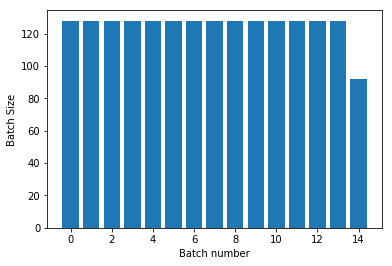

In [30]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)


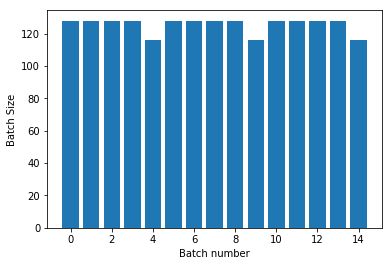

In [31]:
titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [34]:
epochs = 3
dataset =titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ",epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


In [35]:
#Random shuffling input data
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset =dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

In [37]:
n ,line_batch = next(iter(dataset))
print(n.numpy())

[  9  75  45  49  11   4  36  47  18  77  64  96  25 100  35   2  98  52
 103  66]


In [47]:
dataset =tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[618 590 508 560 336 551 516 604 555 503]
[459 573 593 615 626 558 430 606 554 601]
[499 488 588 609 624 623 598 549]
[ 20  83  91  18  38  52  88  76  82 107]
[ 84  63  42  64  93  86  77  23 114 110]


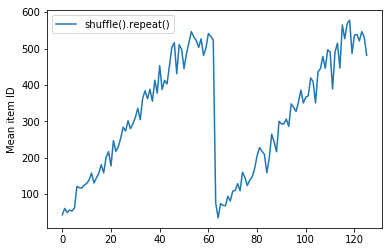

In [48]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [49]:
dataset =tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[172   0 536 495 534  74 613  66  25  76]
[  2  45  29  35   1 608  65 427  61 460]
[ 22 612  15 461 425 505   9  78 445 584]
[572  48  68 104   4 522 617  44 581  71]
[614 502  63 110  95 599  41  96 604 102]


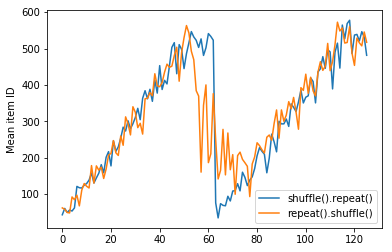

In [51]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

In [0]:
import pathlib

In [0]:
#Decoding image dataset
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [0]:
#Read an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape
def parse_image(filename):
  parts = tf.strings.split(file_path, '/')
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128,128])
  return image, label

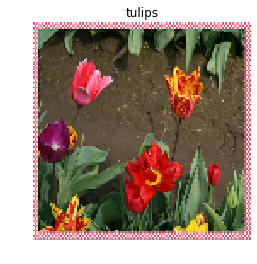

In [74]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image,label)

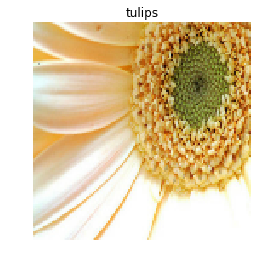

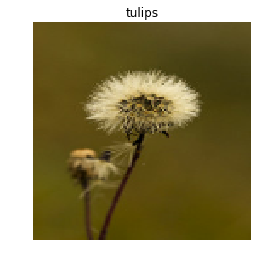

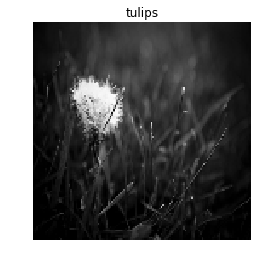

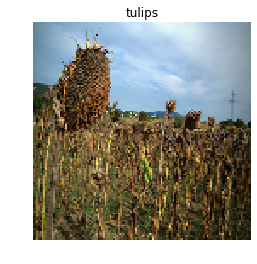

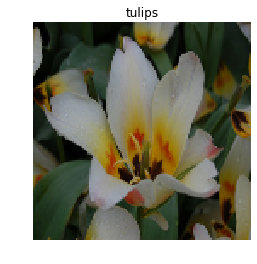

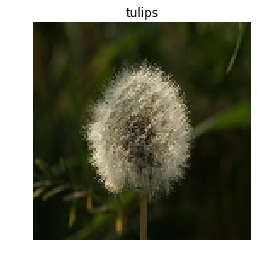

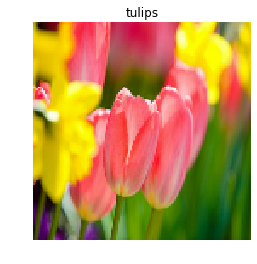

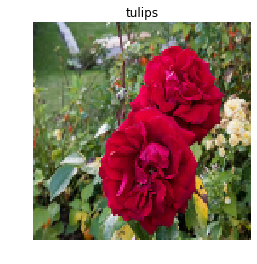

In [76]:
images_ds = list_ds.map(parse_image)
for image, label in images_ds.take(8):
  show(image, label)


In [0]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30,30), reshape= False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


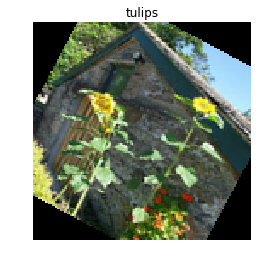

In [80]:
image, label = next(iter(images_ds))
image =random_rotate_image(image)
show(image, label)

In [0]:
def tf_random_rotate_image(image, label):
  im_shape =image.shape
  [image,] = tf.py_function(random_rotate_image,[image],[tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


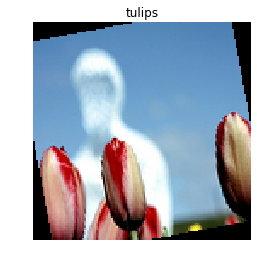

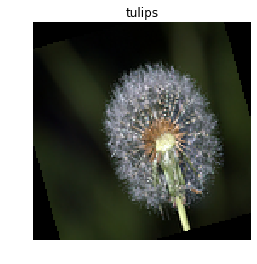

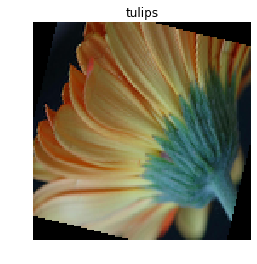

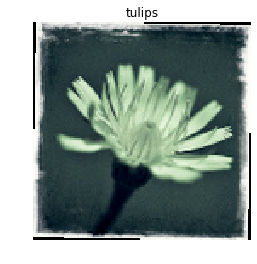

In [82]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(4):
  show(image, label)

#Using High level APIs

*  **tf.keras**
*  **tf.estimator**



In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

# Build a simple model
**Sequential model**


In [85]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2961 - accuracy: 0.9144
Epoch 2/5
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1473 - accuracy: 0.9559
Epoch 3/5
60000/60000 [==============================] - 7s 114us/sample - loss: 0.1092 - accuracy: 0.9668
Epoch 4/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0891 - accuracy: 0.9724
Epoch 5/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0778 - accuracy: 0.9757
10000/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08090958587825298, 0.9746]

# tf.estimator